# EDA: Wine Cultivars

[Wine dataset](https://archive.ics.uci.edu/dataset/109/wine) - chemical analysis to determine the origin of wines. 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import load_wine
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helpers.base_imports import *

## Create new EDA

In [3]:
eda = EDA(name="winec")
eda

Loading 'edas.csv'
Creating experiment: 'winec'


EDA: winec
Columns: Index(['description', 'n features', 'n samples', 'f/n ratio', 'noise', 'stats',
       'class balance', 'outliers', 'skewness', 'correlations',
       'DR potential'],
      dtype='object')
Datasets: Index([], dtype='object', name='dataset')

## Get raw dataset from remote source

In [4]:
# fetch dataset
data = load_wine(as_frame=True)
data.frame.head(5)

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

In [5]:
list(data.target_names)

[np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]

In [6]:
disp_df(data.frame)

In [7]:
X = data.frame.drop(columns="target")
y = data.frame.target
X.shape, y.shape

((178, 13), (178,))

In [9]:
eda.update_param(
    "description", "Classify wines into 3 classes based on chemical analysis"
)
eda.update_param("n features", X.shape[1])
eda.update_param("n samples", X.shape[0])
eda.update_param("f/n ratio", len(data.target_names) / X.shape[0])

In [10]:
eda.summary_df

description n features  \
dataset                                                                 
winec    Classify wines into 3 classes based on chemica...         13   

        n samples f/n ratio noise stats class balance outliers skewness  \
dataset                                                                   
winec         178  0.016854   NaN   NaN           NaN      NaN      NaN   

        correlations DR potential  
dataset                            
winec            NaN          NaN

## Noise

In [11]:
# check for missing values
X.isna().sum().sum()

np.int64(0)

In [12]:
eda.update_param("noise", "None, no missing vals")

## Stats

In [13]:
skewness = X.skew()
summary_stats = X.describe().T
summary_stats["skewness"] = skewness
disp_df(summary_stats[["min", "max", "mean", "std", "skewness", "25%", "50%", "75%"]])

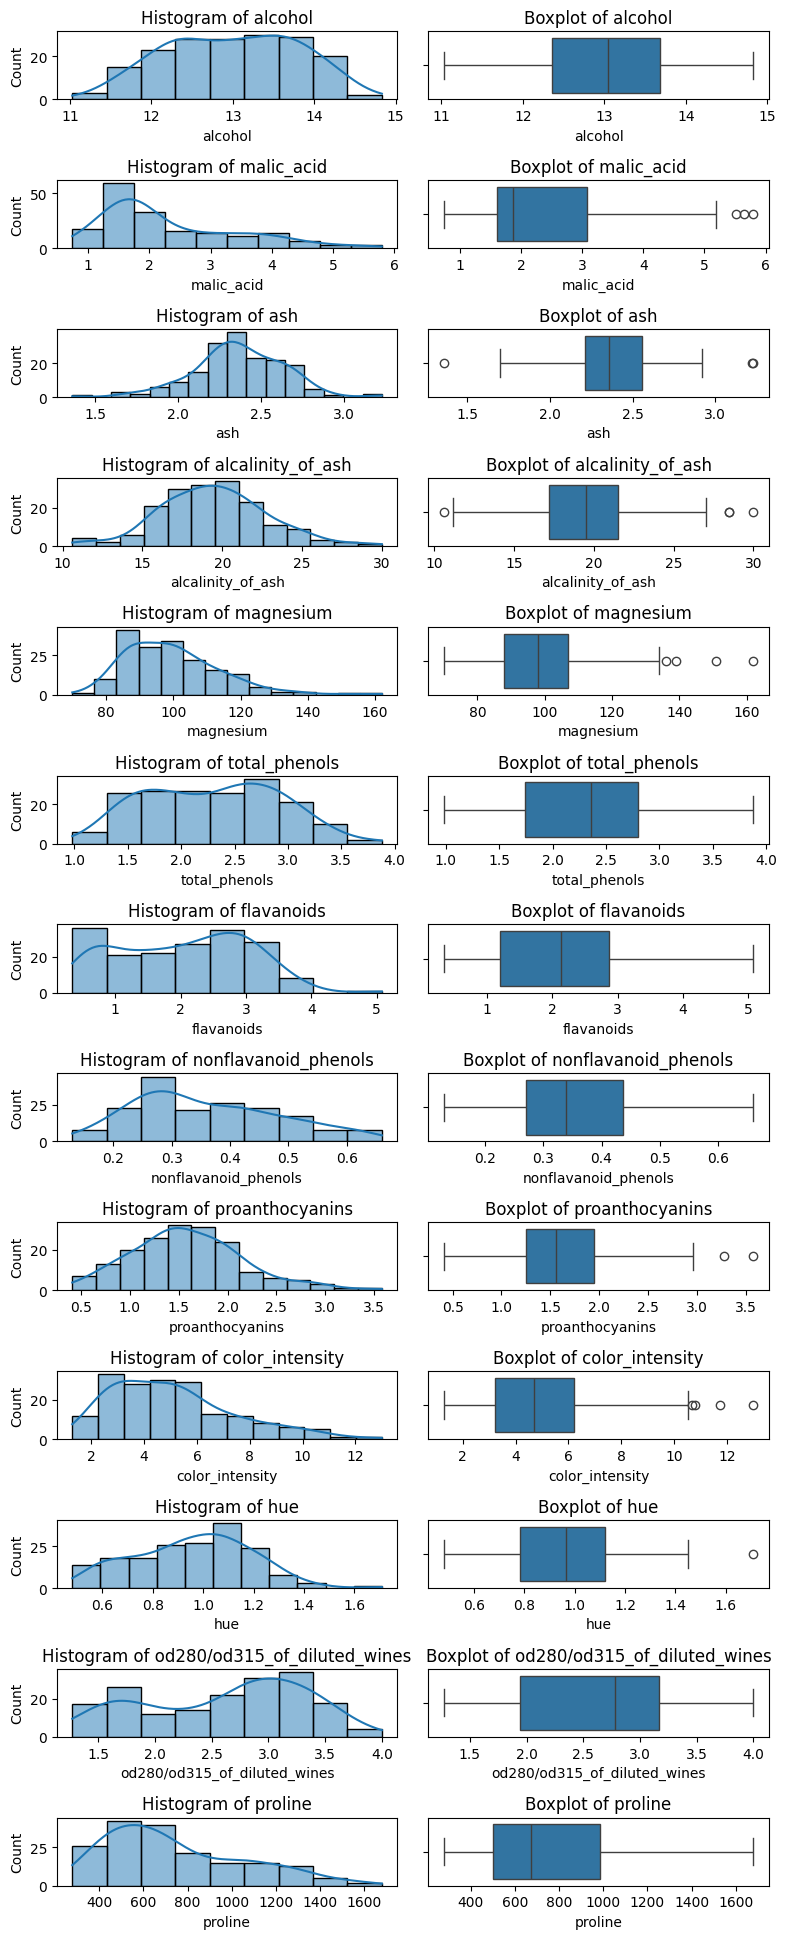

In [14]:
fig, ax = plot_feature_statistics(X, X.columns, line=False)
fig.savefig(f"{FIGS_DIR}/{eda.name}_feature-statistics.png")

In [15]:
eda.update_param("skewness", "some skewness")
eda.update_param("stats", "fine")
eda.update_param("outliers", "some outliers in ~7 features")

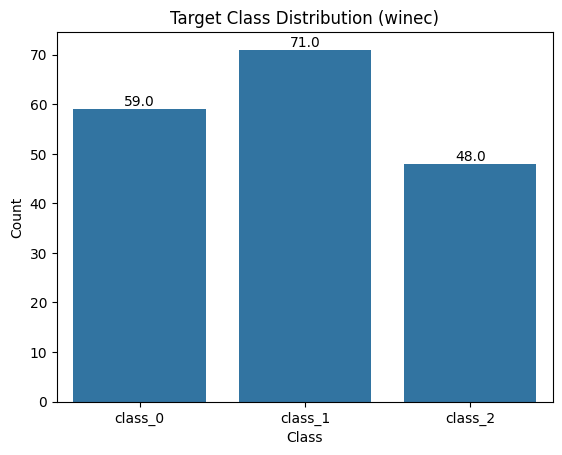

In [16]:
# class distribution of whole dataset
ax = sns.countplot(x=data.target_names[y])
plt.title(f"Target Class Distribution ({eda.name})")
plt.xlabel("Class")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{eda.name}_target-class-distribution.png")
plt.show()

In [17]:
eda.update_param("class balance", "~Imbalanced (59, 71, 48)")

## Feature Correlations

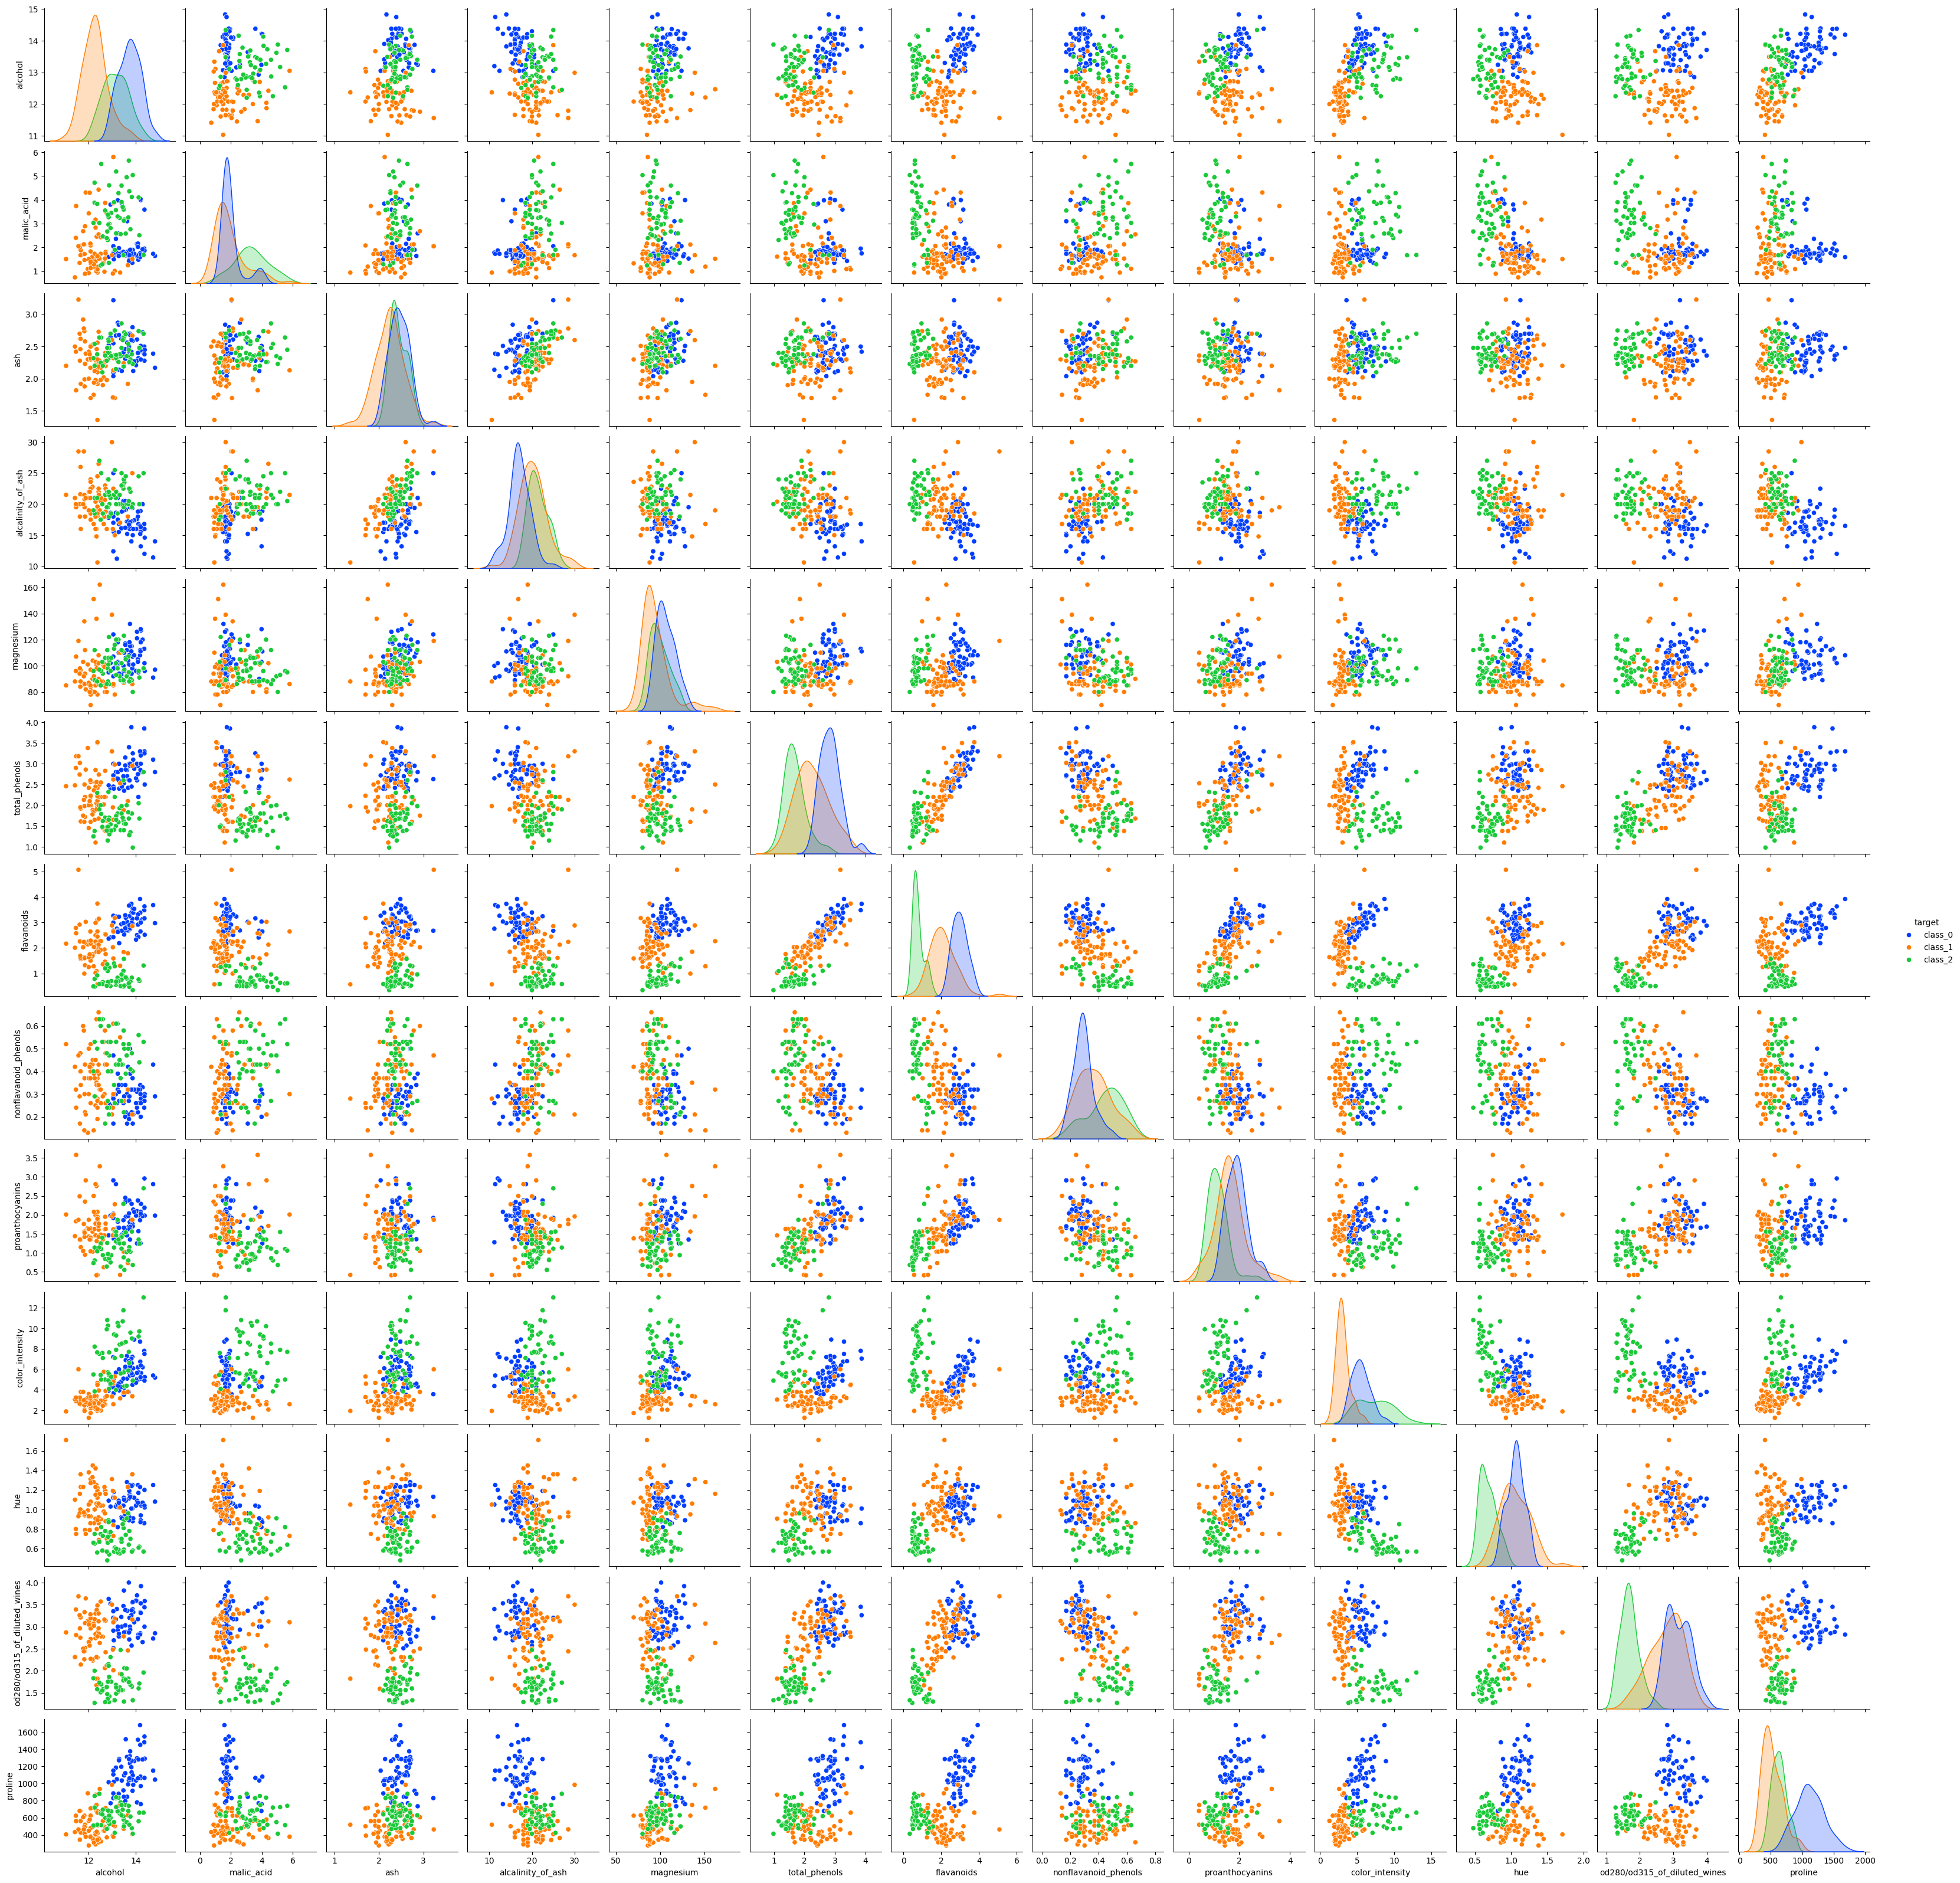

In [18]:
df = data.frame.copy()
df["target"] = data.target_names[y]
# df.head(5)
sns.pairplot(data=df, hue="target", palette="bright")
plt.savefig(f"{FIGS_DIR}/{eda.name}_pairplot.png")

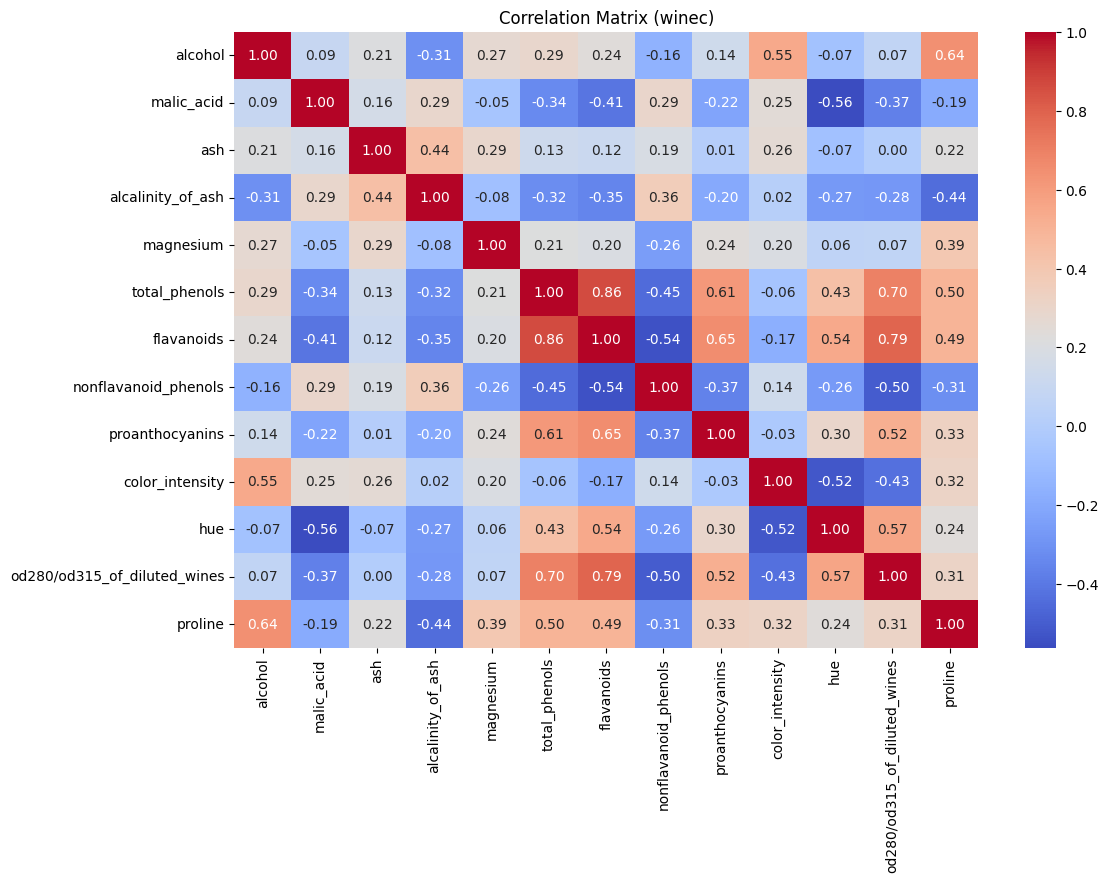

In [19]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Matrix ({eda.name})")

plt.savefig(f"{FIGS_DIR}/{eda.name}_correlation-matrix.png")
plt.show()

In [20]:
eda.update_param("correlations", "a couple medium-strong correlations, but not much")

## Dimensionality Reduction Potential

In [21]:
# PCA - number of components to explain 95% variance
pca_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
    ]
)
pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

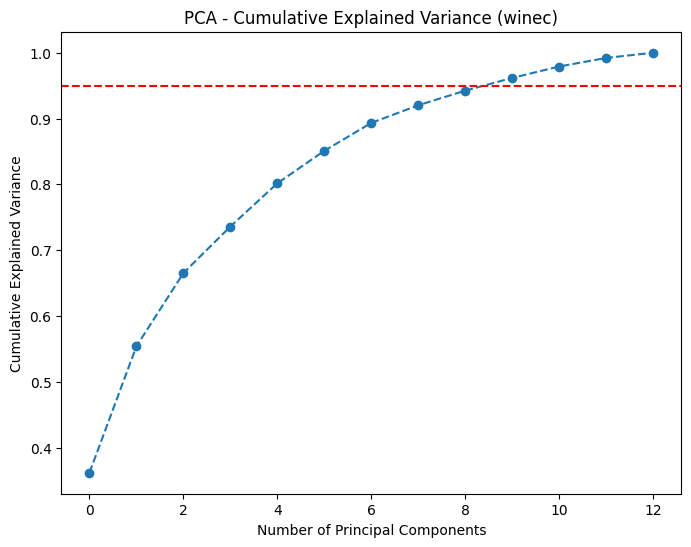

Number of components to explain 95% of the variance: 10


In [22]:
explained_variance_ratio = pca_pipe.named_steps["pca"].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title(f"PCA - Cumulative Explained Variance ({eda.name})")
plt.axhline(y=0.95, color="r", linestyle="--")  # Threshold for 95% explained variance
plt.show()

# Number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to explain 95% of the variance: {num_components_95}")

In [23]:
# ICA - number of independent components
ica_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("ica", FastICA()),
    ]
)
components = ica_pipe.fit_transform(X)

# Number of independent components
num_independent_components = components.shape[1]
print(f"Number of independent components found: {num_independent_components}")

Number of independent components found: 13


/Users/yarik/vc_projects/ML/ml-prep/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [24]:
eda.update_param(
    "DR potential",
    "PCA: 95% variance explained with 10 components\nICA: 13 independent components",
)

## Save EDA results

In [25]:
eda.save()

Loading 'edas.csv'
Saving winec to results/edas.csv


---

# Create and save a shuffled 80/20 train/test split